1. maybe run HMM or confidence interval to decide when regime changes and model fails. or add it into screener 
2. Build out screener
3. Make an options screener to screen for alerts and backtested profitability while remaining within regime. 
4. PCA and greeks to optimize features /done
5. Remove lag /done
6. Make the model a triple barrier: make it more robust in labeling / generating correct classes 
7. drop features when not predictive
8. weight trades by probability 
9. do a screener that tests prediction power with the hgb model 

Screener filter ideas: 
1. price * volume > 600M
2. roc over a period >0
3. SMA for period or moving rate of change positive trending 
4. low implied volatility 
5. good near expiry options volume 
6. near expiry decreasing volatility
Other ideas: HMM screener to detect consistent current option regime 
7. Make a gradient boost screener that can find stocks poised at low iv/hv with increasing volume/price/option feature for options trading, 

In [43]:
import pandas as pd 
import numpy as np 
import os
import pandas as pd

desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "datafix.csv")
datafix = pd.read_csv(desktop_path)


In [44]:
datafix = datafix.set_index("Date")


In [45]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# --- Black-Scholes Greeks calculation (without Rho) ---
def bs_greeks(S, K, T, r, sigma, option_type):
    # S: Stock price
    # K: Strike price
    # T: Time to expiry in years
    # r: Risk-free rate (set to 0.0 if unknown)
    # sigma: Implied volatility (as decimal, not percent)
    # option_type: 'call' or 'put'
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan, np.nan, np.nan, np.nan  # Handle invalid/missing data
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        delta = norm.cdf(d1)
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 - r * K * np.exp(-r * T) * norm.cdf(d2))
    else:
        delta = norm.cdf(d1) - 1
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
                 + r * K * np.exp(-r * T) * norm.cdf(-d2))
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return delta, gamma, vega, theta

# --- Apply to DataFrame ---
r = 0.0  # Risk-free rate, adjust if needed

def calc_row_greeks(row):
    S = row['stock price']
    K = row['strike']
    T = max(row['days_to_expiry'] / 365, 1e-6)  # Avoid division by zero
    sigma = row['IV']
    option_type = row['type'].lower()
    return bs_greeks(S, K, T, r, sigma, option_type)

greeks = datafix.apply(calc_row_greeks, axis=1, result_type='expand')
greeks.columns = ['delta', 'gamma', 'vega', 'theta']
datafix = pd.concat([datafix, greeks], axis=1)


In [46]:
import matplotlib.pyplot as plt
def plot(name):
    column_to_plot = name  # Replace with your actual column name

    if column_to_plot in datafix.columns:
     datafix[column_to_plot].plot(kind='line', title=f"{column_to_plot} Chart")
     plt.xlabel("Index")
     plt.ylabel(column_to_plot)
     plt.show()
    else:
        print(f"Column '{column_to_plot}' not found in datafix DataFrame.")


In [47]:
import numpy as np

# Standardize MACD_Hist using a rolling window (e.g., 50 periods)
window = 20
datafix["MACD_Hist_std"] = (
    (datafix["MACD_Hist"] - datafix["MACD_Hist"].rolling(window).mean()) /
    datafix["MACD_Hist"].rolling(window).std()
)



In [48]:
from arch import arch_model

# Drop NaN values from 'IV' for modeling
iv_series = datafix['IV'].dropna()

# Fit a GARCH(1,1) model to the IV series
model = arch_model(iv_series, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit(disp='off')

# Get the conditional variance (volatility estimate) for each point
conditional_variance = model_fit.conditional_volatility

# Align the conditional volatility with the original dataframe's index
# This will fill NaN for rows where 'IV' was NaN
datafix['IV_garch_vol'] = conditional_variance.reindex(datafix.index)
datafix["GarchRoc"] = datafix['IV_garch_vol'].pct_change()
datafix["GarchRoc5sma"] = datafix["GarchRoc"].rolling(3).mean()
datafix["GarchSma"] = datafix['IV_garch_vol'].rolling(14).mean()
datafix["GarchSmaSpread"] = datafix['IV_garch_vol']-datafix["GarchSma"]

from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
spread_values = datafix['GarchSmaSpread'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler = StandardScaler()
standardized_spread = scaler.fit_transform(spread_values)

# Add the standardized spread back to the dataframe
datafix['GarchSmaSpread_std'] = standardized_spread
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc5sma_values = datafix['GarchRoc5sma'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_roc5sma = StandardScaler()
standardized_roc5sma = scaler_roc5sma.fit_transform(garchroc5sma_values)

# Add the standardized GarchRoc5sma back to the dataframe
datafix['GarchRocsma_std'] = standardized_roc5sma
from sklearn.preprocessing import StandardScaler

# Reshape the data for the scaler
garchroc_values = datafix['GarchRoc'].values.reshape(-1, 1)

# Initialize and fit the scaler
scaler_garchroc = StandardScaler()
standardized_garchroc = scaler_garchroc.fit_transform(garchroc_values)

# Add the standardized GarchRoc back to the dataframe
datafix['GarchRoc_std'] = standardized_garchroc


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.724e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [49]:
import pandas as pd

def compute_rsi(df, column="Close", period=14):
    # Calculate price differences
    delta = df[column].diff()
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate exponential moving averages of gains and losses
    avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    # Add RSI to dataframe
    df['RSI'] = rsi
    return df

compute_rsi(datafix)
# Calculate 14-period moving average of the 'Close' column
datafix['rsiMA_14'] = datafix['RSI'].rolling(window=14).mean()



In [50]:
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,...,IV_garch_vol,GarchRoc,GarchRoc5sma,GarchSma,GarchSmaSpread,GarchSmaSpread_std,GarchRocsma_std,GarchRoc_std,RSI,rsiMA_14
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-03 16:49:00,0.80,0.80,0.79,0.79,12,0.786545,0.539067,0.018874,0.017144,0.001731,...,0.182604,-0.000765,-0.003452,0.184374,-0.001770,-0.850451,-1.281252,-0.138021,63.898834,63.678857
2025-07-03 16:50:00,0.81,0.81,0.79,0.81,18,0.795005,1.075654,0.020699,0.017855,0.002845,...,0.182485,-0.000651,-0.001131,0.184157,-0.001672,-0.797912,-0.380326,-0.113207,68.268941,64.041653
2025-07-03 16:52:00,0.79,0.80,0.79,0.80,21,0.798868,0.485829,0.021096,0.018503,0.002593,...,0.183486,0.005483,0.001356,0.184027,-0.000541,-0.191249,0.584921,1.222915,64.091359,64.420688
2025-07-03 16:53:00,0.78,0.78,0.78,0.78,1,0.796436,-0.304332,0.019570,0.018717,0.000854,...,0.184015,0.002883,0.002572,0.183993,0.000021,0.110352,1.056857,0.656617,56.627796,64.061037
2025-07-03 16:54:00,0.81,0.84,0.81,0.83,12,0.807566,1.397449,0.022141,0.019401,0.002740,...,0.182714,-0.007070,0.000432,0.183825,-0.001112,-0.497192,0.226408,-1.511502,66.980284,64.249325
2025-07-03 16:55:00,0.83,0.83,0.81,0.83,12,0.816181,1.066712,0.023903,0.020302,0.003601,...,0.182758,0.000245,-0.001314,0.183623,-0.000865,-0.364944,-0.451289,0.081820,66.980284,64.437613
2025-07-03 16:56:00,0.83,0.85,0.82,0.82,91,0.820134,0.484329,0.024213,0.021084,0.003129,...,0.182373,-0.002106,-0.002977,0.183431,-0.001058,-0.468255,-1.096760,-0.430215,63.466484,64.374915
2025-07-03 16:57:00,0.82,0.83,0.82,0.82,15,0.823038,0.354120,0.024180,0.021703,0.002477,...,0.182238,-0.000745,-0.000869,0.183256,-0.001018,-0.447141,-0.278505,-0.133740,63.466484,64.312218
2025-07-03 16:58:00,0.85,0.85,0.85,0.85,7,0.833055,1.217080,0.026271,0.022617,0.003655,...,0.182348,0.000605,-0.000749,0.183108,-0.000760,-0.308575,-0.231921,0.160259,69.105484,64.433314


In [51]:
#MACD IV
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='IV_garch_vol', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDvol'] = macd
    df['Signalvol'] = signal_line
    df['MACD_Histvol'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='IV_garch_vol', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histvol']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

datafix['MACDROCvol'] = macdata['MACD_Histvol'].pct_change()

In [52]:
#MACD KALMAN
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Kalman', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACDkalman'] = macd
    df['Signalkalman'] = signal_line
    df['MACD_Histkalman'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Kalman', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Histkalman']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0
datafix['MACDROCkal'] = macdata['MACD_Histkalman'].pct_change()
datafix['MACDROC'] = macdata['MACD_Hist'].pct_change()
datafix['VolumeSMA9'] = datafix['Volume'].rolling(9).mean()
datafix['VolumeSMA26'] = datafix['Volume'].rolling(26).mean()

In [53]:
lag = 9 
# Precompute the rolling mean of Kalman_Roc (window=3)
datafix["Kalman_Roc_roll"] = datafix["Kalman_Roc"].rolling(lag).mean()
datafix["MACDROCvolroll9"] = datafix["MACDROCvol"].rolling(9).mean()
datafix["MACDROCkalroll9"] = datafix["MACDROCkal"].rolling(9).mean()

# assign other variables -- stocksma can be a screener filter along with volume and implied volatility 
datafix["stocktrend"] = datafix["stock price"].pct_change().rolling(3).mean()
datafix["sma30"] = datafix["Close"].rolling(20).mean()
datafix["smaspread"] = datafix["sma30"] - datafix["Close"] 

# no MACDs 
datafix["IV_garch_volsma"] = datafix['IV_garch_vol'].pct_change().rolling(18).mean()
datafix["kalmansma"] = datafix['Kalman'].pct_change().rolling(5).mean()

In [54]:
import numpy as np
from hmmlearn.hmm import GaussianHMM

# Calculate daily log returns from the 'Close' column
datafix['log_return'] = np.log(datafix['Close'] / datafix['Close'].shift(1))
returns = datafix['log_return'].dropna().values.reshape(-1, 1)

# Fit HMM (e.g., with 3 states)
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
model.fit(returns)

# Predict hidden states for each day
hidden_states = model.predict(returns)

# Add hidden states to your DataFrame (align index after dropna)
datafix = datafix.iloc[1:]  # because the first return is NaN
datafix['hmm_state'] = hidden_states


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/2681209349.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['hmm_state'] = hidden_states


In [55]:
# Random forest settings 
buy_thresh = 0.20  # Threshold for buy signal(probability of rf outcome) df.2
sell_thresh = -0.20  # Threshold for sell signal(probability of rf outcome) df-.2
neighbors = 5
backtest_ma = 3 # Buy/sell moving average for rolling RF signal and backtest | keep same as stat window df20

In [56]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

# --- Local extrema detection (as labels, not features) ---
series = datafix['Kalman'].values
order = neighbors  # Adjust for sensitivity (higher = fewer extrema)

# Find local maxima (tops) and minima (bottoms)
max_idx = argrelextrema(series, np.greater, order=order)[0]
min_idx = argrelextrema(series, np.less, order=order)[0]

# Create extrema label columns (safe for supervised learning)
datafix['BuyLabel'] = 0
datafix['SellLabel'] = 0
datafix.iloc[min_idx, datafix.columns.get_loc('BuyLabel')] = 1
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Your feature engineering code remains unchanged ---

# Calculate rolling averages for features
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# Define features (do NOT include extrema columns to avoid lookahead bias)
features = [
    "kalmansma",
    "IV_garch_vol",
    "VolumeSMA9",
    "Close",
    "stock price", 
    "MACD_Hist",
    "Kalman_Roc",
    "delta",
    "gamma",
    "vega",
    "theta",
    "hmm_state"
]

# Drop rows with missing values in features or label for training
model_data = datafix.dropna(subset=features + ["BuyLabel"])

X = model_data[features]
y = model_data["BuyLabel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.6)

# Use HistGradientBoostingClassifier (handles NaNs natively)
hgb = HistGradientBoostingClassifier(
    max_iter=100,      # Number of boosting iterations (trees)
    learning_rate=0.1, # Step size shrinkage
    max_depth=3,       # Maximum depth of individual trees
    random_state=42,
    class_weight='balanced'
)
hgb.fit(X_train, y_train)

# Predict signals (no need to drop or impute NaNs in datafix[features])
model_data["Predicted_Signal"] = hgb.predict(X)
datafix["Predicted_Signal"] = hgb.predict(datafix[features])

# If you want to train for SellLabel as well, repeat with y = model_data["SellLabel"]


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/3996224926.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['BuyLabel'] = 0
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/3996224926.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['SellLabel'] = 0
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/3996224926.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [57]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier

# Assume datafix is your DataFrame and 'Kalman' is your smoothed price series

# --- Local maxima detection for SellLabel ---
order = neighbors  # Sensitivity: higher = fewer, more prominent maxima
series = datafix['Kalman'].values

# Find local maxima (tops)
max_idx = argrelextrema(series, np.greater, order=order)[0]

# Create SellLabel: 1 at local maxima, 0 elsewhere
datafix['SellLabel'] = 0
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Feature engineering (example) ---
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()



# Prepare data for ML
model_data = datafix.dropna(subset=features + ["SellLabel"])
X = model_data[features]
y = model_data["SellLabel"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.6)

# Train classifier (renamed to hgb_sell)
hgb_sell = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    class_weight='balanced'  # Optional: balance classes if needed
)
hgb_sell.fit(X_train, y_train)

# Predict signals
model_data["Predicted_Sell"] = hgb_sell.predict(X)
datafix["Predicted_Sell"] = hgb_sell.predict(datafix[features])


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/1798244714.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['SellLabel'] = 0
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/1798244714.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/1798244714.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [58]:
# Get probabilities (assuming binary classification, class 1 is buy/sell)
datafix["Buy_Prob"] = hgb.predict_proba(datafix[features])[:, 1]
datafix["Sell_Prob"] = hgb_sell.predict_proba(datafix[features])[:, 1]

# Weighted difference (you can adjust the weights)
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]

# Define thresholds for action
def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/223477919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Buy_Prob"] = hgb.predict_proba(datafix[features])[:, 1]
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/223477919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Sell_Prob"] = hgb_sell.predict_proba(datafix[features])[:, 1]
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/223477919.py:6: SettingWithCopyWarning: 
A value is tryin

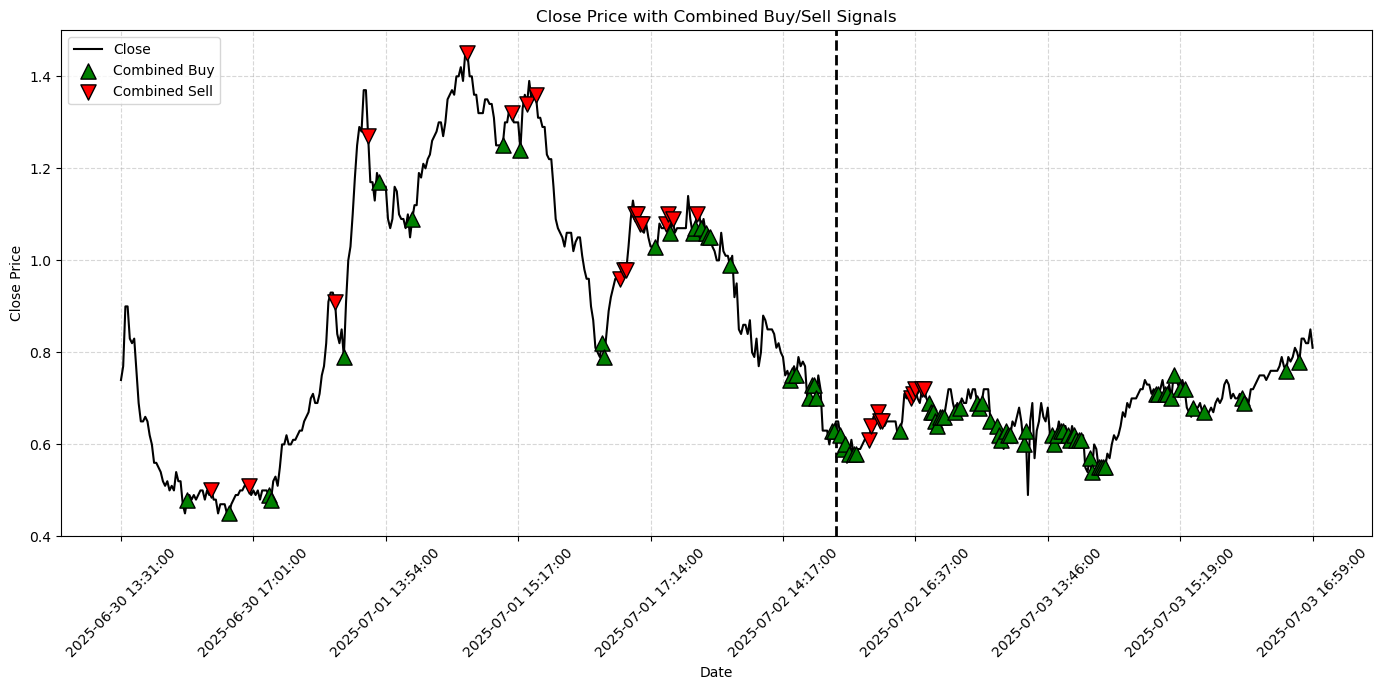

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Plot the close price
plt.plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)

# Plot combined buy signals (green upward triangle)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
plt.scatter(
    buy_signals.index,
    buy_signals["Close"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Combined Buy",
    zorder=3
)

# Plot combined sell signals (red downward triangle)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
plt.scatter(
    sell_signals.index,
    sell_signals["Close"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Combined Sell",
    zorder=3
)

plt.title("Close Price with Combined Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

# Draw prediction start line
split_idx_bar = int(len(datafix) * 0.6)
split_date_bar = datafix.index[split_idx_bar]
plt.axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label='Prediction Start')

# Show only 10 x-axis date labels (no .strftime() since index is string)
n_labels = 10
if len(datafix.index) > n_labels:
    idxs = np.linspace(0, len(datafix.index) - 1, n_labels, dtype=int)
    dates = [datafix.index[i] for i in idxs]
    plt.xticks(dates, dates, rotation=45)
else:
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/3149753067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/3149753067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=backtest_ma, center=False).mean()


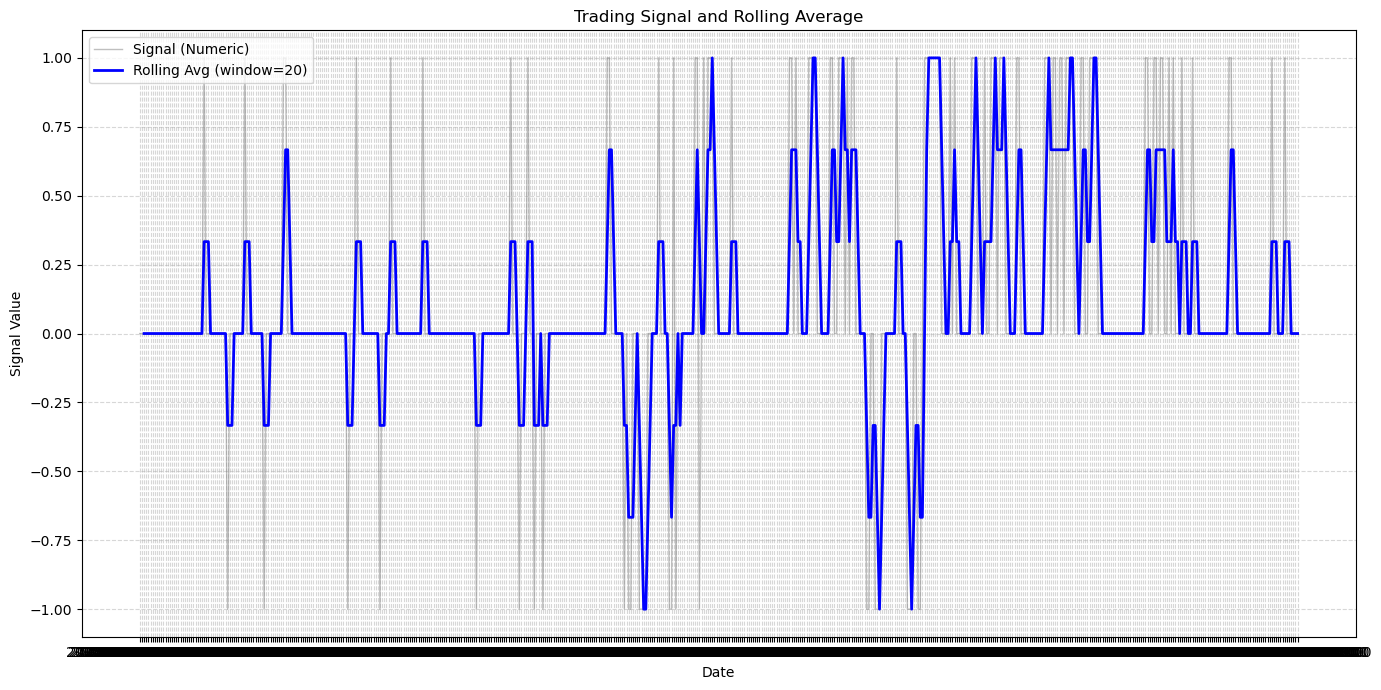

In [60]:
# Map signals to numeric: buy=1, sell=-1, hold=0 (example)
signal_map = {"buy": 1, "sell": -1, "hold": 0}
datafix["Signal_Num"] = datafix["Combined_Signal"].map(signal_map)

# Rolling average
datafix["Rolling_Signal_Num"] = datafix["Signal_Num"].rolling(window=backtest_ma, center=False).mean()

# Plot similarly as above
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Plot the numeric signal (buy=1, sell=-1, hold=0)
plt.plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)

# Plot the rolling average of the signal
plt.plot(
    datafix.index,
    datafix["Rolling_Signal_Num"],
    label=f"Rolling Avg (window={20})",
    color="blue",
    linewidth=2
)

plt.title("Trading Signal and Rolling Average")
plt.xlabel("Date")
plt.ylabel("Signal Value")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


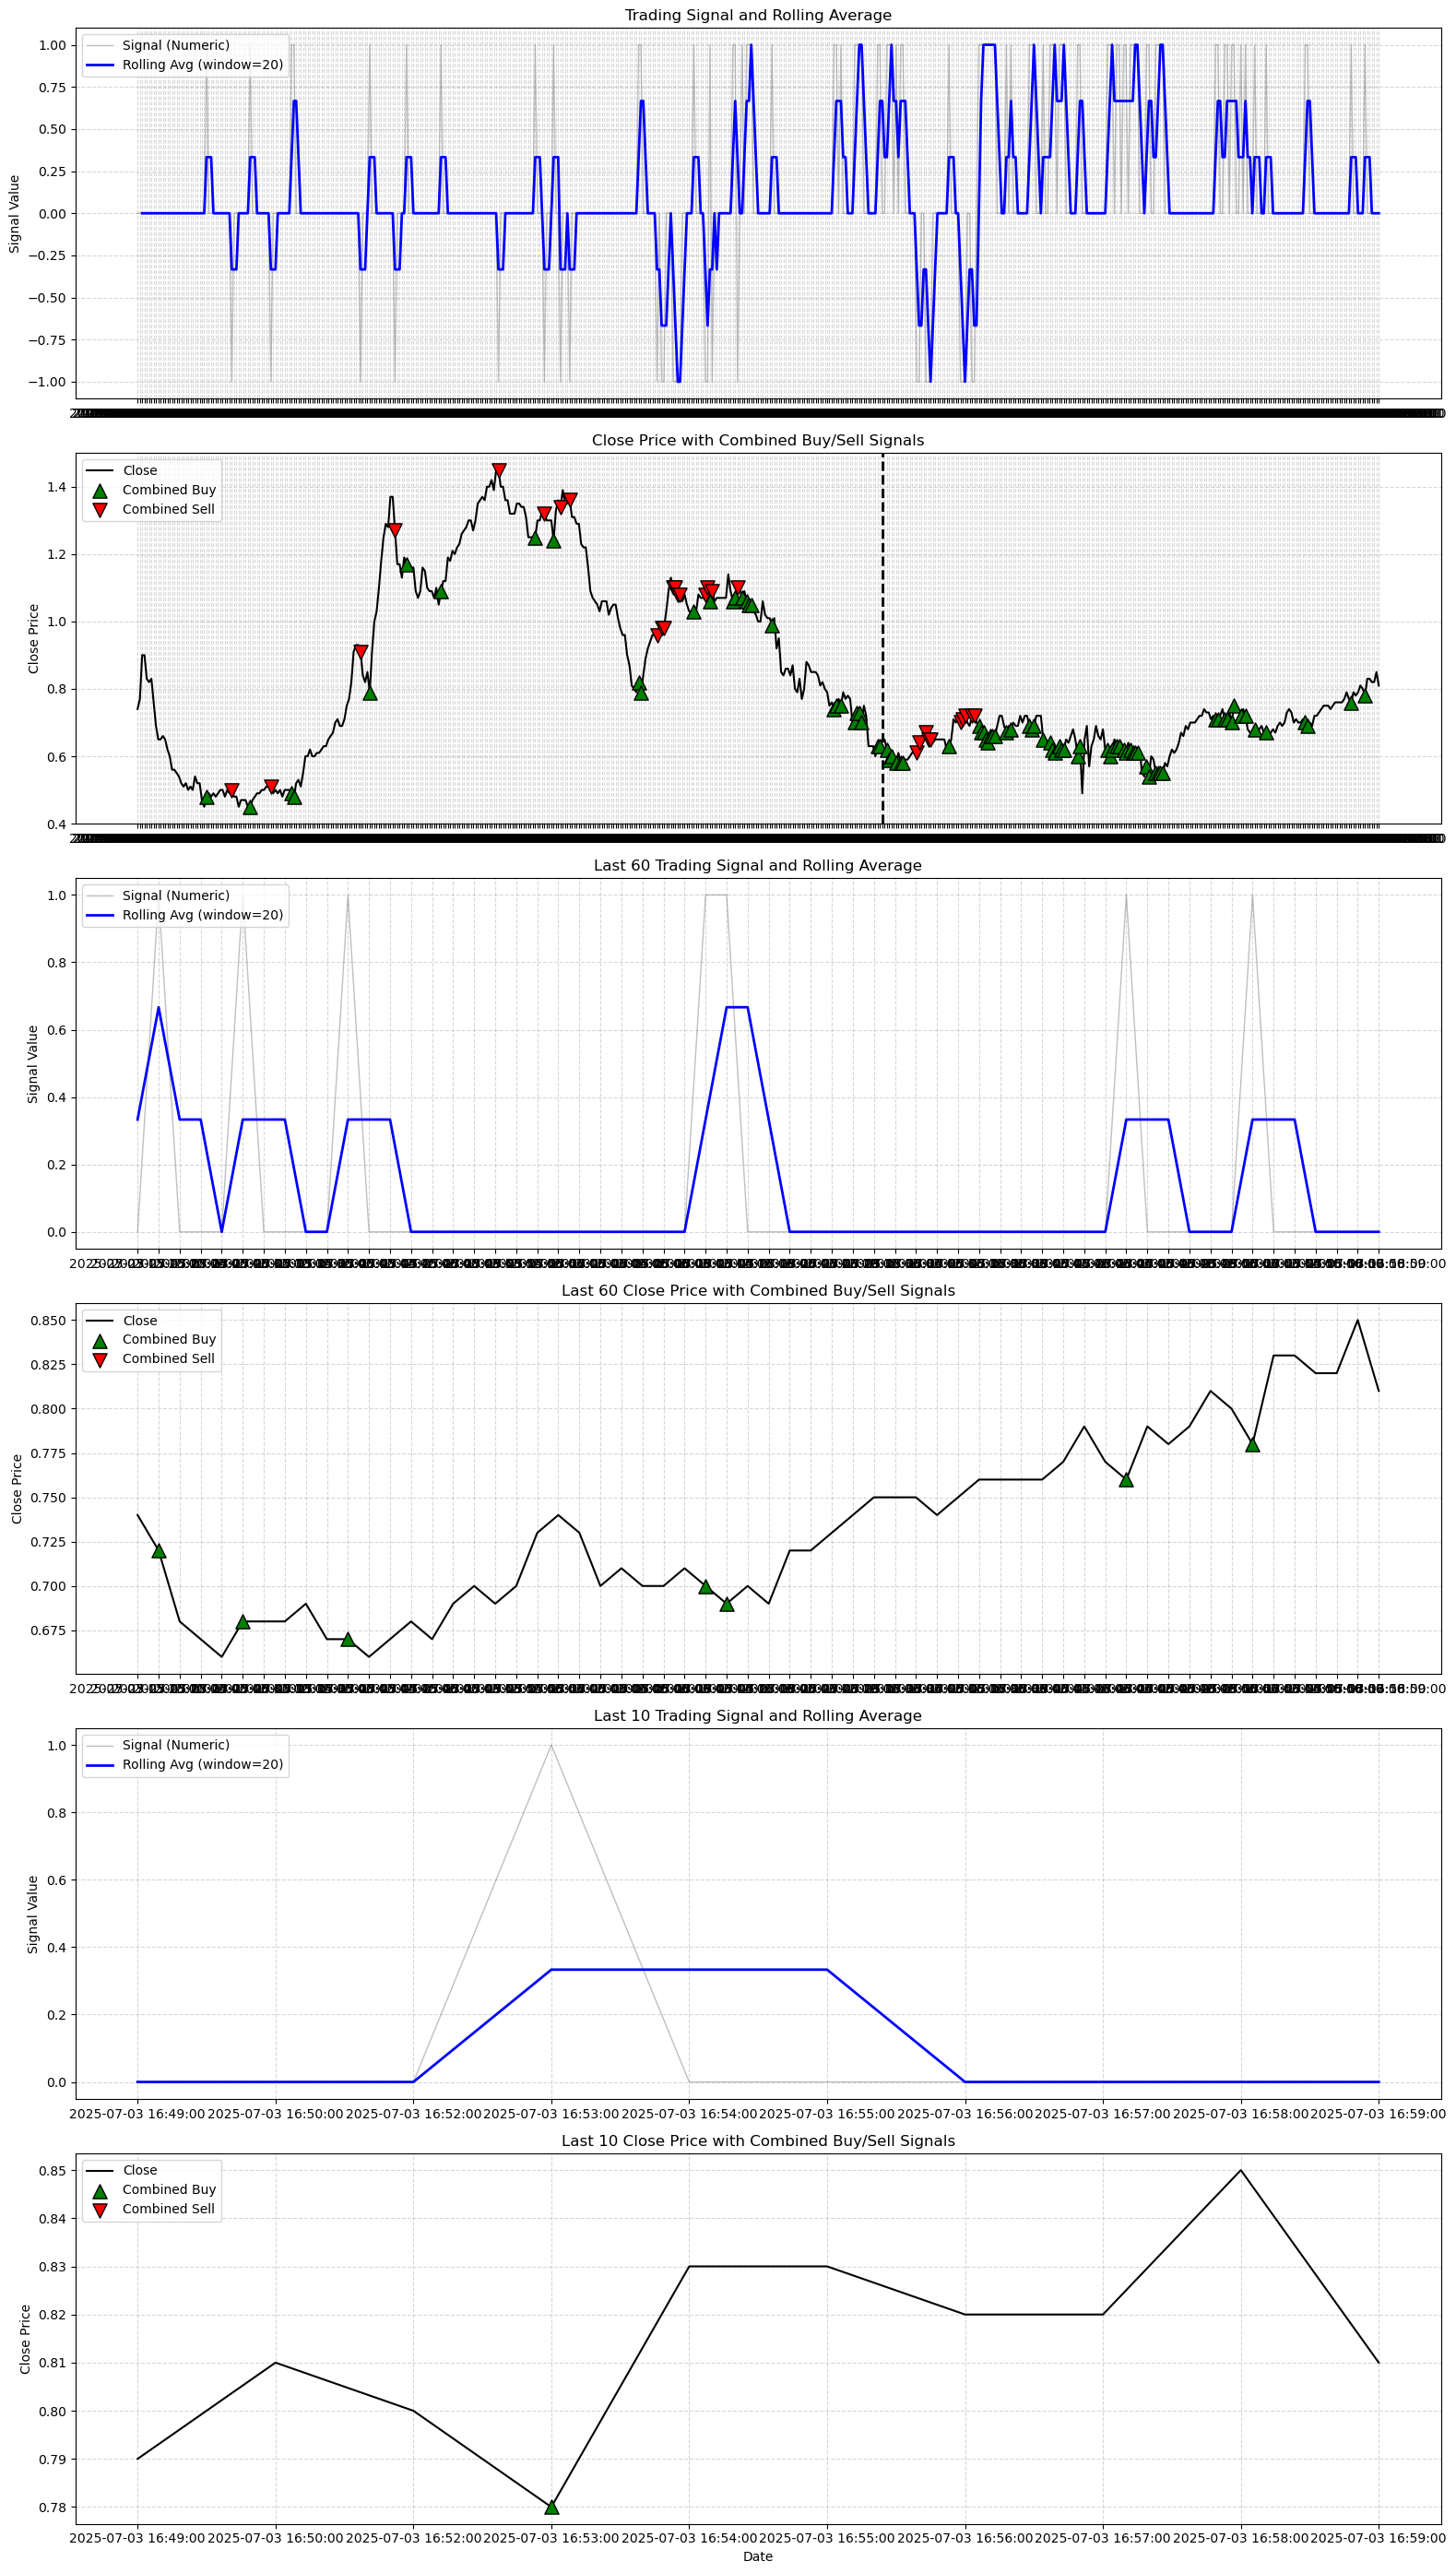

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(16, 28), sharex=False, sharey=False)

# --- Full range charts (first two) ---
axes[0].plot(datafix.index, datafix["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[0].plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[0].set_ylabel("Signal Value")
axes[0].set_title("Trading Signal and Rolling Average")
axes[0].legend(loc="upper left")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].plot(datafix.index, datafix["Close"], label="Close", color="black", linewidth=1.5)
buy_signals = datafix[datafix["Combined_Signal"] == "buy"]
axes[1].scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals = datafix[datafix["Combined_Signal"] == "sell"]
axes[1].scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[1].set_ylabel("Close Price")
axes[1].set_title("Close Price with Combined Buy/Sell Signals")
axes[1].legend(loc="upper left")
axes[1].grid(True, linestyle='--', alpha=0.5)
split_idx_bar = int(len(datafix) * 0.6)
split_date_bar = datafix.index[split_idx_bar]
axes[1].axvline(x=split_date_bar, color='black', linestyle='--', linewidth=2, label='Prediction Start')

# --- Last 60 datapoints charts (independent axes) ---
last60 = datafix.tail(60)
axes[2].plot(last60.index, last60["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[2].plot(last60.index, last60["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[2].set_ylabel("Signal Value")
axes[2].set_title("Last 60 Trading Signal and Rolling Average")
axes[2].legend(loc="upper left")
axes[2].grid(True, linestyle='--', alpha=0.5)

axes[3].plot(last60.index, last60["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last60 = last60[last60["Combined_Signal"] == "buy"]
axes[3].scatter(buy_signals_last60.index, buy_signals_last60["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last60 = last60[last60["Combined_Signal"] == "sell"]
axes[3].scatter(sell_signals_last60.index, sell_signals_last60["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[3].set_ylabel("Close Price")
axes[3].set_title("Last 60 Close Price with Combined Buy/Sell Signals")
axes[3].legend(loc="upper left")
axes[3].grid(True, linestyle='--', alpha=0.5)

# --- Last 10 datapoints charts (independent axes) ---
last10 = datafix.tail(10)
axes[4].plot(last10.index, last10["Signal_Num"], label="Signal (Numeric)", color="gray", alpha=0.5, linewidth=1)
axes[4].plot(last10.index, last10["Rolling_Signal_Num"], label="Rolling Avg (window=20)", color="blue", linewidth=2)
axes[4].set_ylabel("Signal Value")
axes[4].set_title("Last 10 Trading Signal and Rolling Average")
axes[4].legend(loc="upper left")
axes[4].grid(True, linestyle='--', alpha=0.5)

axes[5].plot(last10.index, last10["Close"], label="Close", color="black", linewidth=1.5)
buy_signals_last10 = last10[last10["Combined_Signal"] == "buy"]
axes[5].scatter(buy_signals_last10.index, buy_signals_last10["Close"], marker="^", color="green", edgecolor="black", s=120, label="Combined Buy", zorder=3)
sell_signals_last10 = last10[last10["Combined_Signal"] == "sell"]
axes[5].scatter(sell_signals_last10.index, sell_signals_last10["Close"], marker="v", color="red", edgecolor="black", s=120, label="Combined Sell", zorder=3)
axes[5].set_ylabel("Close Price")
axes[5].set_title("Last 10 Close Price with Combined Buy/Sell Signals")
axes[5].legend(loc="upper left")
axes[5].grid(True, linestyle='--', alpha=0.5)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/508776490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['ROC'] = datafix['Rolling_Signal_Num'].diff(n)
/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_43068/508776490.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafix['Trade_Signal'] = stateful_signals(datafix['ROC'], datafix['Rolling_Signal_Num'])


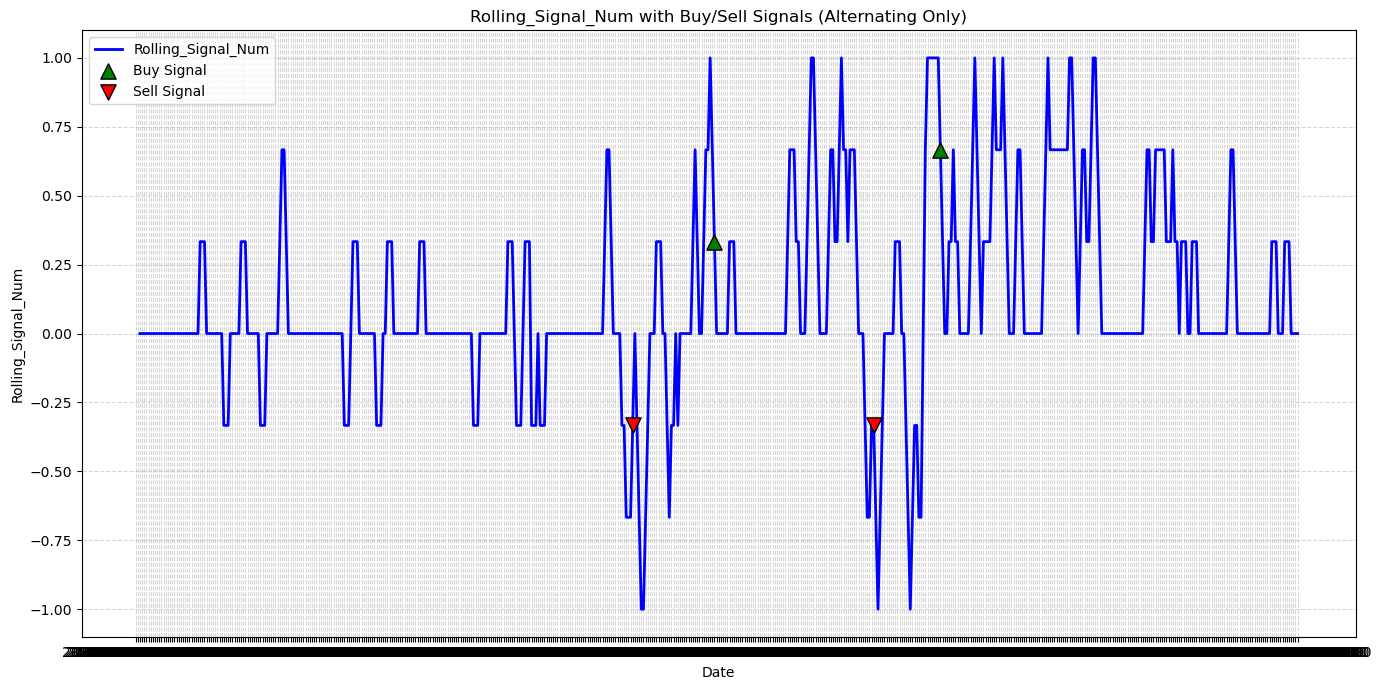

In [62]:
n = 3  # or whatever period you want
datafix['ROC'] = datafix['Rolling_Signal_Num'].diff(n)

def stateful_signals(roc, rolling_signal):
    signals = []
    position = 0  # 0 = flat, 1 = long (buy active), -1 = short (sell active)
    for r, s in zip(roc, rolling_signal):
        if position == 0:
            if (r < 0) and (s > 0):
                signals.append(1)    # Buy
                position = 1
            elif (r > 0) and (s < 0):
                signals.append(-1)   # Sell
                position = -1
            else:
                signals.append(0)    # Hold
        elif position == 1:
            if (r > 0) and (s < 0):
                signals.append(-1)   # Sell
                position = -1
            else:
                signals.append(0)    # Hold
        elif position == -1:
            if (r < 0) and (s > 0):
                signals.append(1)    # Buy
                position = 1
            else:
                signals.append(0)    # Hold
    return signals

datafix['Trade_Signal'] = stateful_signals(datafix['ROC'], datafix['Rolling_Signal_Num'])
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot the Rolling_Signal_Num line
plt.plot(datafix.index, datafix["Rolling_Signal_Num"], label="Rolling_Signal_Num", color="blue", linewidth=2)

# Plot buy signals (green upward triangles)
buy_signals = datafix[datafix['Trade_Signal'] == 1]
plt.scatter(
    buy_signals.index,
    buy_signals["Rolling_Signal_Num"],
    marker="^",
    color="green",
    edgecolor="black",
    s=120,
    label="Buy Signal",
    zorder=3
)

# Plot sell signals (red downward triangles)
sell_signals = datafix[datafix['Trade_Signal'] == -1]
plt.scatter(
    sell_signals.index,
    sell_signals["Rolling_Signal_Num"],
    marker="v",
    color="red",
    edgecolor="black",
    s=120,
    label="Sell Signal",
    zorder=3
)

plt.title("Rolling_Signal_Num with Buy/Sell Signals (Alternating Only)")
plt.xlabel("Date")
plt.ylabel("Rolling_Signal_Num")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Total Return (Last 40%): 6.99%


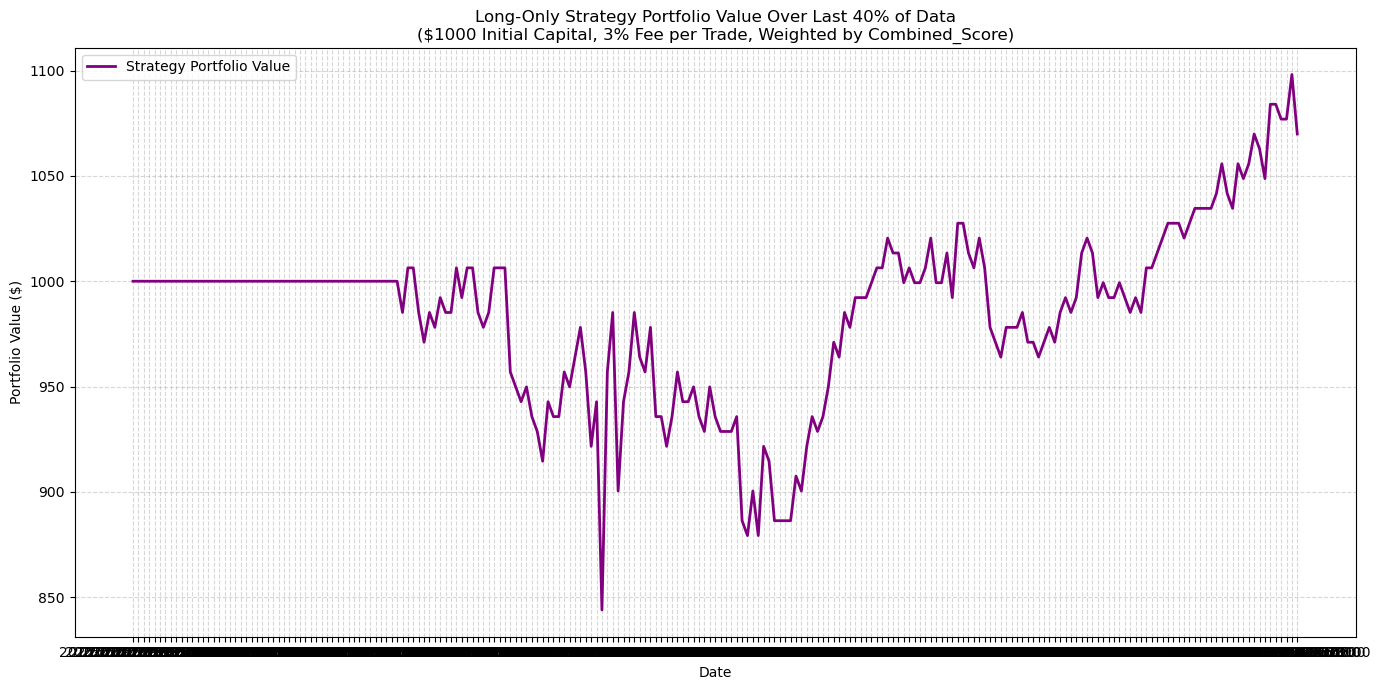


Selected columns from the last 40% of data:
                     Close  Combined_Score Combined_Signal
Date                                                      
2025-07-03 16:49:00   0.79        0.487263            hold
2025-07-03 16:50:00   0.81        0.490099            hold
2025-07-03 16:52:00   0.80        0.497026            hold
2025-07-03 16:53:00   0.78        0.921512             buy
2025-07-03 16:54:00   0.83        0.490236            hold
2025-07-03 16:55:00   0.83        0.490237            hold
2025-07-03 16:56:00   0.82        0.476959            hold
2025-07-03 16:57:00   0.82        0.493181            hold
2025-07-03 16:58:00   0.85        0.490106            hold
2025-07-03 16:59:00   0.81        0.580246            hold


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Slice the last 40% of the data ---
start_idx = int(len(datafix) * 0.6)
datafix_last40 = datafix.iloc[start_idx:].copy()

# --- 2. Normalize Combined_Score to [0, 1] if needed ---
if datafix_last40['Combined_Score'].max() > 1 or datafix_last40['Combined_Score'].min() < 0:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    datafix_last40['Combined_Score'] = scaler.fit_transform(datafix_last40[['Combined_Score']])

# --- 3. Initialize variables ---
initial_capital = 1000
capital = initial_capital
position = 0  # 1 for long, 0 for flat
positions = []
portfolio = []
entry_price = None
fee_rate = 0.03  # 3% trading fee
allocation = 0   # Fraction of capital allocated to position

# --- 4. Backtest loop with weighted allocation ---
for idx, row in datafix_last40.iterrows():
    signal = row['Trade_Signal']
    price = row['Close']
    score = row['Combined_Score']

    # Enter trade: allocate capital based on Combined_Score
    if signal == 1 and position == 0:
        allocation = score
        position = 1
        entry_price = price
        capital = capital * (1 - allocation * fee_rate)  # Apply entry fee only to allocated capital

    # Exit trade: deallocate, apply exit fee
    elif signal == -1 and position == 1:
        position = 0
        # Only allocated capital participates in trade
        capital = capital * (1 - allocation) + capital * allocation * (price / entry_price) * (1 - fee_rate)
        entry_price = None
        allocation = 0

    # Portfolio value: unallocated cash + value of current position
    if position == 1:
        portfolio_value = capital * (1 - allocation) + capital * allocation * (price / entry_price)
    else:
        portfolio_value = capital

    portfolio.append(portfolio_value)
    positions.append(position)

# --- 5. Attach results ---
datafix_last40['Position'] = positions
datafix_last40['Portfolio'] = portfolio

# --- 6. Calculate total return ---
total_return = (datafix_last40['Portfolio'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"Total Return (Last 40%): {total_return:.2f}%")

# --- 7. Plot ---
plt.figure(figsize=(14, 7))
plt.plot(datafix_last40.index, datafix_last40['Portfolio'], label='Strategy Portfolio Value', color='purple', linewidth=2)
plt.title('Long-Only Strategy Portfolio Value Over Last 40% of Data\n($1000 Initial Capital, 3% Fee per Trade, Weighted by Combined_Score)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 8. Create and show the selected DataFrame ---
# (Assumes you have a 'Combined_Signal' column in your data)
df_selected_last40 = datafix_last40.loc[:, ['Close', 'Combined_Score', 'Combined_Signal']]
print("\nSelected columns from the last 40% of data:")
print(df_selected_last40.tail(10))
